Initially, we'll just look at all single predictors of 30-day readmission.

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn import preprocessing as pp
from sklearn.preprocessing import Imputer
import statsmodels.discrete.discrete_model as sm
import math
import warnings 
warnings.filterwarnings("ignore") # Ignore annoying warnings
import matplotlib.pyplot as plt

from logisticSmoothing import smoothedLookupEstimator
from sklearn.grid_search import GridSearchCV

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)


$$P(x) = \frac{1}{1 + e^{-(\beta_0 + \sum_{i}\beta_i x_i)}} $$

There are a few different variables in this dataset that include readmission data. READMISSION is depricated, but still has data for older records. READMISSION1 is the current variable. It makes sense to try to merge these to be our regression target. No records have data for both. Of the 19533 records, 4537 don't have readmission data recorded either way. To start we'll just assume that these patients were not readmitted.

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# For now we'll impute those missing values...
# imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=False)
# imp.fit(y.reshape(-1,1))
# y = imp.transform(y.reshape(-1,1))

Now we need to make a predictor array to use for logistic regression, dropping our source data columns in the process. We also need to drop variables that will be post-hoc predictors. For example, patients that get reoperated will of course be readmitted, so this isn't a helpful predictor. Because dropping tons of variables is cumbersome, we include an option to just keep explicitly named columns. Note that after dropping rows with NaN in y, some variables no longer have more than one unique value. We drop these explicitly if necessary.

In [3]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Either drop or keep columns from cdf
dropOrKeep = False
if dropOrKeep:
    dropList = ['READMISSION-','READMISSION1-','REOPERATION-',\
                'REOPERATION1-','NWNDINFD-','WNDINFD-','DEHIS-','NDEHIS-',\
                'MORBPROB','NSUPINFEC-','SUPINFEC-','RETORPODAYS','OTHSYSEP',\
                'NOTHSYSEP-']
    colsToDrop = [colName for colName in cdf.columns if np.any([dropItem in colName for dropItem in dropList])]
    cdf = cdf.drop(colsToDrop,1)
    print('Dropped some variables: ')
    print(colsToDrop)
    # These are being dropped automatically by Imputer
    colsToDrop = [ 4,5,6,16,17,18,137,191,192,193,194,195,212,213,214,236,237,238,\
                  239,284,285,316,317,350,351,411,412,413,414,505,506,507,514,517]
    cdf = cdf.drop(cdf.columns[colsToDrop],axis=1)
    
else:
    # Dropping these columns is super-cumbersome. Let's find a list to keep
    # Need to add in RBC and FNSTATUS1
    keepList = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','DIABETES',\
                'SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT','HXCOPD','CPNEUMON',\
                'HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED','HXPVD','RENAFAIL','DIALYSIS',\
                'CVA','DISCANCR','WNDINF','STEROID','WTLOSS','BLEEDDIS','PROPER30','ASACLASS',\
                'ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH','PRWBC'\
                'PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY']
    colsToKeep = [colName for colName in cdf.columns if np.any([keepItem in colName for keepItem in keepList])]
    cdf = cdf[colsToKeep]
    
# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
cdf = imp.transform(cdf)
cdf = pd.DataFrame(cdf, columns=colNames)

To start, let's just cycle through each variable independently, printing out variables that have significant (before multiple comparisons corrections) predictive value. 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.0s finished


Bootstrapping confidence intervals...


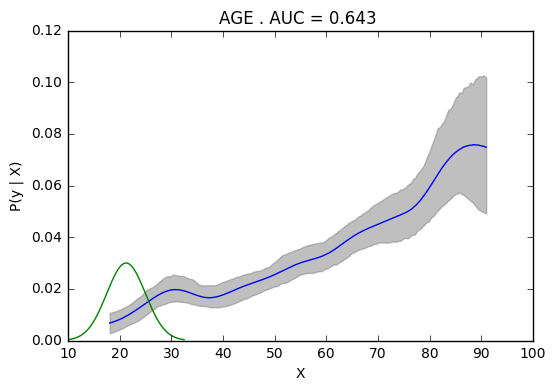

*** ANESTHES-Monitored Anesthesia Care: Exception ***
*** CPNEUMON-Yes: Exception ***
*** DCNSCVA-3.0: Exception ***
*** DIABETES-ORAL: Exception ***
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.4s finished


Bootstrapping confidence intervals...


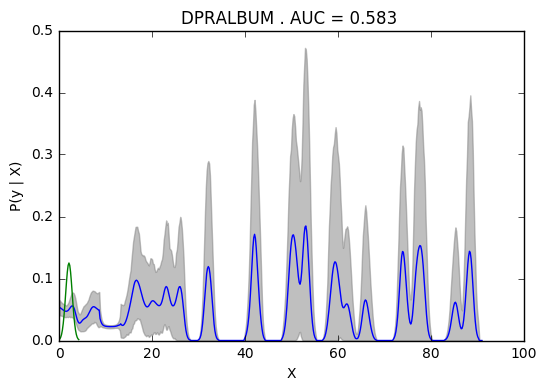

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.1s finished


Bootstrapping confidence intervals...


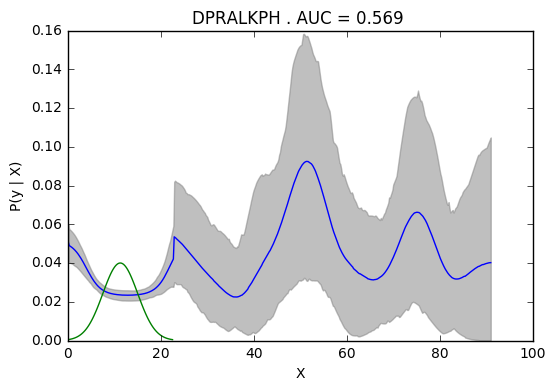

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.5s finished


Bootstrapping confidence intervals...


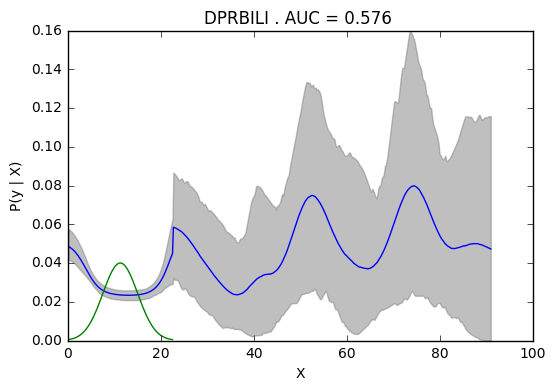

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.1s finished


Bootstrapping confidence intervals...


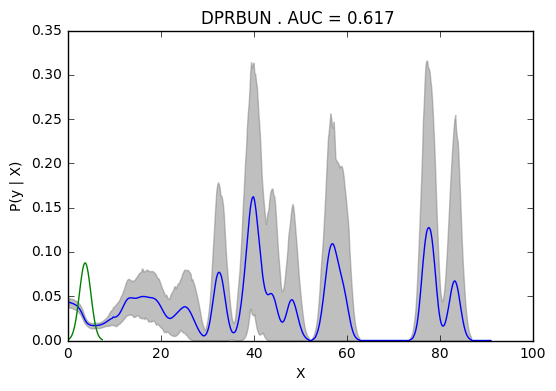

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.5s finished


Bootstrapping confidence intervals...


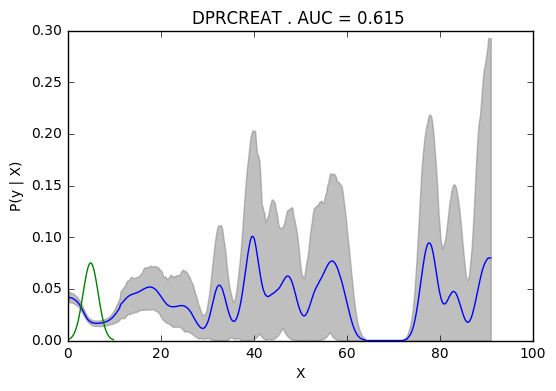

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.9s finished


Bootstrapping confidence intervals...


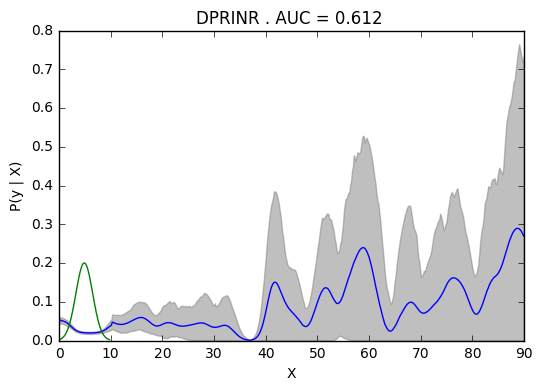

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.8s finished


Bootstrapping confidence intervals...


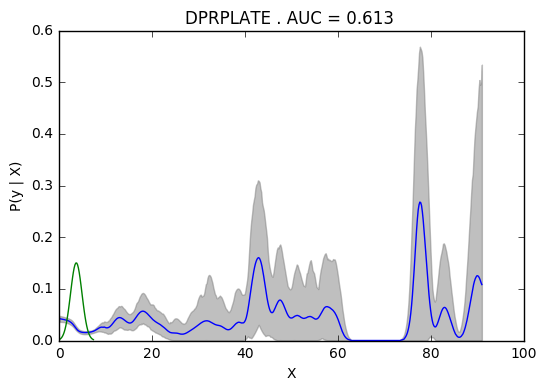

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.1s finished


Bootstrapping confidence intervals...


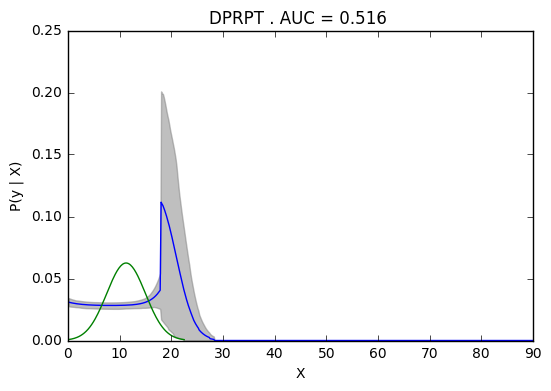

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.1s finished


Bootstrapping confidence intervals...


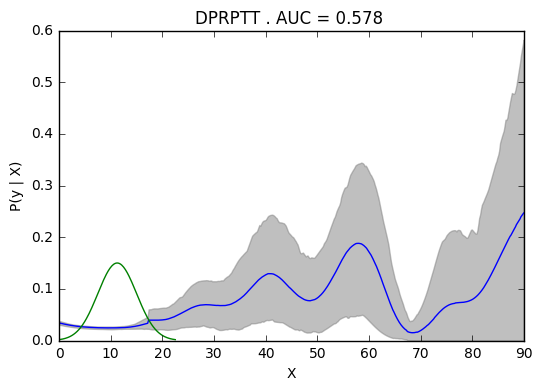

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.9s finished


Bootstrapping confidence intervals...


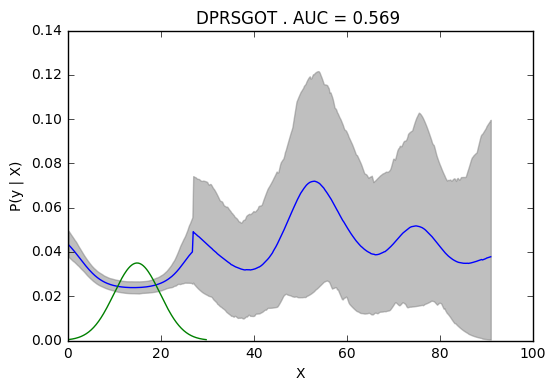

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.9s finished


Bootstrapping confidence intervals...


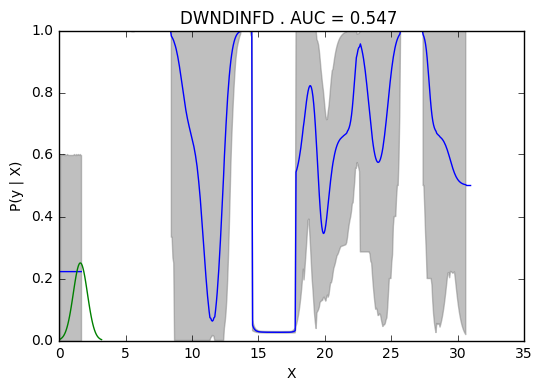

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.2s finished


Bootstrapping confidence intervals...


ValueError: could not broadcast input array from shape (578) into shape (512)

In [4]:
fitResults = pd.DataFrame(np.nan, index=[], columns=['colName','pValue','coeff'])

for colName in cdf.columns:

    # colName = 'AGE'
    X = cdf[colName]
    X = np.asarray(X).reshape(-1,1)
    
    if len(np.unique(X)) > 4:
    
        plt.figure()
        sle = smoothedLookupEstimator(nBins=512)
        tuned_parameters = [{'sigma': np.logspace(-1,1.3,20,base=10)}]
        gscv = GridSearchCV(sle,tuned_parameters,cv=10,verbose=1)
        gscv.fit(X, y)
        sle = gscv.best_estimator_
        sle.bootModelCI(X,y,200,0.05)
        sle.plotModel(plt.gca())
        plt.title('%s | AUC = %.3f ' % (colName, gscv.best_score_))
        plt.show()
    
    
    X = np.concatenate((X, np.ones([X.shape[0],1])),axis=1) # Add an intercept term

    try:
        logit = sm.Logit(y, X)
        smresult = logit.fit(disp=False)
        # print(smresult.summary())
        # if smresult.pvalues[0] < 0.05:
        #    print('Var: ' + colName + '  logP = %.2f    Coeff = %.2f' % (math.log10(smresult.pvalues[0]), \
        #                                                                   smresult.params[0]))
        fitResults = fitResults.append(pd.Series({'colName': colName, \
                                                  'pValue': smresult.pvalues[0], \
                                                  'coeff': smresult.params[0]}),ignore_index=True)
        # else:
        #    print('Var: ' + colName)
            
    except:
        print('*** ' + colName + ': Exception ***')


In [ ]:
fitResults = fitResults.sort_values(by='pValue') 
print(fitResults)